# Predicting Car Market Value with Machine Learning: A Fast and Accurate Model for Rusty Bargain
Rusty Bargain, a used car sales service, is developing an app to help customers quickly estimate the market value of their vehicles. To support this initiative, I will build a predictive model using historical data, including technical specifications and prices. The model must balance three key priorities: prediction quality, inference speed, and training efficiency.

This project will involve training multiple models, including linear regression (as a baseline), a random forest, and gradient boosting methods such as LightGBM and CatBoost. These models will be evaluated using the Root Mean Squared Error (RMSE) metric to assess prediction accuracy. Additionally, I will compare model training times and prediction speeds to ensure that the final model is both accurate and efficient.

By the end of this project, I aim to deliver a well-optimized model that can provide fast and reliable car price predictions, helping Rusty Bargain enhance its customer experience and attract new users to its platform.

## Data preparation

This project will rely on pandas for data manipulation, numpy, matplotlib, and seaborn for visualizing data, and scikit-learn for building and training the model.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

import lightgbm as lgb
from lightgbm.callback import early_stopping

from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split

### Opening and Exploring Data Sets

In [2]:
cars = pd.read_csv('/datasets/car_data.csv')

In [3]:
cars

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# changing column names to lowercase
cars.columns = cars.columns.str.lower()
cars.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [6]:
cars.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


The full dataset includes information for over 350k cars with 16 parameters.  No car exceeds 20k€ in value or 150k miles, so the cars are, indeed, a rusty bargain!  The majority of cars are over twenty years old, however, and most do, in fact, have 150k miles.

There are some missing values in the vehicletype, gearbox, model, fueltype, and notrepaired columns that will need to be handled, but the data is overall intact.

The numberofpictures column seems to have lost all of its data as all responses are 0.  Thus, it can be dropped.  There appear to be some faulty figures in the registrationyear column.  Registrationyear seems to in fact indicate model year, and thus I will seek to drop erroneous values like the cars from the first and tenth milleniums and fill this column with the average value for the model in question.

### Data Preprocessing

Before proceeding, I will take some basic steps to clean up further the column names for clear code by separating words with an underscore and updating some of the unclear/nontechnical language, e.g. registration year and "brand" (more commonly referred to as "make").

In [7]:
cars.drop('numberofpictures', axis=1, inplace=True)
cars.rename(columns={'datecrawled': 'date_crawled', 'vehicletype': 'type','registrationyear': 'model_year', 'registrationmonth': 'registration_month', 'fueltype': 'fuel_type', 'brand': 'make', 'notrepaired': 'unrepaired', 'datecreated': 'date_created', 'postalcode': 'postal_code', 'lastseen': 'last_seen'}, inplace=True)
cars

,date_crawled,price,type,model_year,gearbox,power,model,mileage,registration_month,fuel_type,make,unrepaired,date_created,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,87439,07/04/2016 07:15


The faulty numberofpictures column has been removed.

In [8]:
cars.duplicated().sum()

262

In [9]:
cars.drop_duplicates(inplace=True)
cars.duplicated().sum()

0

There were 262 duplicates in the data that I removed from the dataset.  It is still a robust dataset of details on over 354k cars.  I will now find solutions to the above-referenced missing data.

In [10]:
cars['type'].isna().sum()

37484

11% of the cars are missing a designated vehicle type.  Filling with 'Unknown' has too much potential to affect predictions.  Therefore, a more creative approach is required.  Given that, in general, model names correspond to a particular vehicle type, I will fill vehicletype--where possible--based on the most common vehicle type for a given model.  Cars without vehicletype or model will need to be dropped from the dataset.

In [11]:
model_to_vt = cars.dropna(subset=['type', 'model'])[['model', 'type']].drop_duplicates()

cars['type'] = cars.apply(lambda row: model_to_vt.loc[model_to_vt['model'] == row['model'], 'type'].values[0] if pd.isnull(row['type']) and row['model'] in model_to_vt['model'].values else row['type'], axis=1)
cars['type'].isna().sum()

6827

In [12]:
cars.dropna(subset=['type'], inplace=True)
cars['type'].isna().sum()

0

Filling vehicletype based on model names allowed over 82% of the affected data to remain as part of the dataset in a meaningful way.  The remaining 18% of the affected data had to be dropped to avoid negative impact on predictions; however, this represents a mere 2% of the total initial dataset.

In [13]:
cars['gearbox'].isna().sum()

16819

Roughly 5% of the remaining cars are missing information on their gearbox type.  Gearbox type tends to have a considerable impact on pricing.  Therefore, preserving this data is ideal.  Similarly to vehicletype, gearbox type can be generally deduced based on model, given that 30% of new cars in Europe are sold with a manual transmission option.  I will use a similar strategy to impute the gearbox type.

In [14]:
model_to_gb = cars.dropna(subset=['gearbox', 'model'])[['model', 'gearbox']].drop_duplicates()

cars['gearbox'] = cars.apply(lambda row: model_to_gb.loc[model_to_gb['model'] == row['model'], 'gearbox'].values[0] if pd.isnull(row['gearbox']) and row['model'] in model_to_gb['model'].values else row['gearbox'], axis=1)
cars['gearbox'].isna().sum()

1119

In [15]:
cars.dropna(subset=['gearbox'], inplace=True)
cars['gearbox'].isna().sum()

0

Filling gearbox based on model named preserved 95% of the affected data.  The remaining 5% was dropped to avoid negative impact on predictions, representing <1% of the initial data.

Next, I will replace the clearly erroneous 'model_year' values with the median year for a given type and model.

In [16]:
#defining valid range
valid_range = (1886, 2025)

#replacing invalid years with NaN
cars['model_year'] = cars['model_year'].apply(lambda x: None if x < valid_range[0] or x > valid_range[1] else x)
cars['model_year'].isna().sum()

96

96 cars have invalid or already missing model_years.  Now, I will impute a reasonable value using the median of each type and model wherever possible.

In [18]:
tm_medians = cars.groupby(['model', 'type'])['model_year'].median()

cars['model_year'] = cars.apply(lambda row: tm_medians.get((row['model'], row['type']), row['model_year']) if pd.isnull(row['model_year']) else row['model_year'], axis=1)
cars['model_year'].isna().sum()

0

This method was successful, eliminating all null values without a loss of data.  Next, I will handle missing model values using predictive imputation.

In [19]:
cars['model'].isna().sum()

11755

3% of cars are missing their model name.  I could simply drop this data, but model names can likely be filled with predictive imputation based on other features such as type, model_year, power, and make.

In [20]:
features = ['type', 'model_year', 'power', 'make']
target = 'model'

train = cars.dropna(subset=['model']).copy()

label_encoders = {}
for col in ['type', 'make']:
    le = LabelEncoder()
    train.loc[:, col] = le.fit_transform(train[col])
    label_encoders[col] = le
    
encoder = LabelEncoder()
train['model'] = encoder.fit_transform(train['model'])

imputer = SimpleImputer(strategy='median')
train[features] = imputer.fit_transform(train[features])

X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.2, random_state=21)

rfc = RandomForestClassifier(n_estimators=25, random_state=21)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7946981250560688

In [21]:
missing_models = cars[cars['model'].isna()].copy()

print(f'Imputing {len(missing_models)} missing model values....')

for col in ['type', 'make']:
    if col in label_encoders:
        missing_models[col] = missing_models[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

missing_models[features] = imputer.transform(missing_models[features])

predicted_models = rfc.predict(missing_models[features])

missing_models['model'] = encoder.inverse_transform(predicted_models)

cars.loc[cars['model'].isna(), 'model'] = missing_models['model']

print(cars['model'].isna().sum(), 'NaN values remaining.')

Imputing 11755 missing model values....
0 NaN values remaining.


The RandomForestClassifier successfully filled all missing model values with the most likely value, thus allowing 3% of data to be retained.

Some fueltype values were missing.  I will now see if I can fill some of them.

In [22]:
cars['fuel_type'].isna().sum()

28046

Roughly 8% of the cars are missing fuel type.  Given that fuel type can significantly impact the value of a car, filling with 'unknown' or with the mode for the data set could skew the data.  However, car models are generally only available with a single fuel type.  Therefore, I will use model value to impute the most likely fuel type for each vehicle.

In [23]:
model_to_ft = cars.dropna(subset=['model', 'fuel_type'])[['fuel_type', 'model']].drop_duplicates()

cars['fuel_type'] = cars.apply(lambda row: model_to_ft.loc[model_to_ft['model'] == row['model'], 'fuel_type'].values[0] if pd.isnull(row['fuel_type']) else row['fuel_type'], axis=1)
cars['fuel_type'].isna().sum()

0

Successfully filled all missing fuel_type values with the most common fuel type for their model, thus preserving 8% of the data intact.

Finally, there are some cars where whether or not they have been repaired is unknown.  For these, while this has a large impact on value, it also is not something we can determine based on other known details about the car.  Therefore, how to handle these values depends on the amount and nature of the data missing.

In [24]:
unknown_repairs = cars[cars['unrepaired'].isna()]
unknown_repairs.describe()

,price,model_year,power,mileage,registration_month,postal_code
count,65940.000000,65940.000000,65940.000000,65940.000000,65940.000000,65940.000000
mean,2700.693797,2002.144184,88.192220,132078.328784,4.624704,48528.073097
std,3386.995317,8.790205,258.069845,38015.059668,4.054897,25297.173766
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,550.000000,1998.000000,0.000000,125000.000000,0.000000,28215.000000
50%,1450.000000,2001.000000,75.000000,150000.000000,4.000000,47166.000000
75%,3499.000000,2006.000000,122.000000,150000.000000,8.000000,66564.000000
max,20000.000000,2019.000000,19211.000000,150000.000000,12.000000,99998.000000


In [25]:
cars['unknown_repair'] = cars['unrepaired'].isnull().astype(int)
correlation = cars.corr()['unknown_repair'].sort_values(ascending=False)
correlation

unknown_repair        1.000000
mileage               0.046355
postal_code          -0.038698
power                -0.059026
model_year           -0.059724
registration_month   -0.151328
price                -0.189699
Name: unknown_repair, dtype: float64

In [26]:
cars.drop(['unknown_repair'], axis=1, inplace=True)

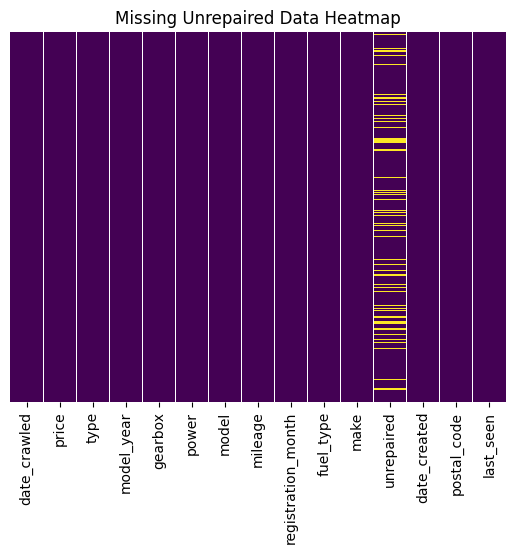

In [27]:
sns.heatmap(cars.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Unrepaired Data Heatmap')
plt.show()

In [28]:
cars.groupby('make')['unrepaired'].apply(lambda x: x.isnull().mean()).sort_values(ascending=False)

make
trabant           0.436293
rover             0.247241
lada              0.246575
daihatsu          0.230088
renault           0.226253
fiat              0.225074
lancia            0.221505
opel              0.218406
mitsubishi        0.212551
volkswagen        0.211452
ford              0.207046
daewoo            0.203065
honda             0.191959
subaru            0.190283
chrysler          0.189496
citroen           0.184597
nissan            0.184064
jeep              0.181409
mazda             0.177354
audi              0.176383
seat              0.175666
porsche           0.173261
jaguar            0.169661
bmw               0.169180
peugeot           0.168216
mercedes_benz     0.167258
chevrolet         0.166764
suzuki            0.164830
alfa_romeo        0.160373
land_rover        0.160221
sonstige_autos    0.157101
smart             0.151367
volvo             0.149211
kia               0.139975
hyundai           0.134803
toyota            0.129103
skoda             0.127

Nearly 1/5 of the data set has missing values for unrepaired.  Compared to the data set as a whole, these cars are on average around 40% cheaper than cars for the data set overall, though their ages, power, and mileage are comparable.  Likewise, for most makes, unknown repair status cars represent 15-25% of the set, with a few outliers (Trabant, Mini). Overall, the missing data has no correlation with other features for the cars.  As dropping the data would result in a sizable loss of data, but filling could affect price predictions by a significant amount, the best option is unclear.  I will explore the statistical distributions of each option before deciding how to proceed.

In [29]:
unrepaired_filled = cars.copy()
unrepaired_filled['unrepaired'].fillna('unknown', inplace=True)

unrepaired_dropped = cars.dropna(subset=['unrepaired'])

print('Unrepaired Filled with Unknown')
print(unrepaired_filled.describe())

print('Unrepaired Unknown Dropped')
print(unrepaired_dropped.describe())

Unrepaired Filled with Unknown
               price     model_year          power        mileage  \
count  346161.000000  346161.000000  346161.000000  346161.000000   
mean     4470.501469    2003.041257     111.321018  128505.911989   
std      4525.692115       7.286226     190.079804   37384.688674   
min         0.000000    1910.000000       0.000000    5000.000000   
25%      1100.000000    1999.000000      69.000000  125000.000000   
50%      2800.000000    2003.000000     105.000000  150000.000000   
75%      6499.000000    2007.000000     143.000000  150000.000000   
max     20000.000000    2019.000000   20000.000000  150000.000000   

       registration_month    postal_code  
count       346161.000000  346161.000000  
mean             5.778739   50584.276851  
std              3.699349   25775.360680  
min              0.000000    1067.000000  
25%              3.000000   30173.000000  
50%              6.000000   49477.000000  
75%              9.000000   71126.000000  
max

Overall, proceeding with the addition of "unknown" repair status seems to be the best option, as it preserves the data in other columns without losing 1/5 of the dataset and statistically both options are similar.

### Data Preparation Conclusion
Through careful data preprocessing, I have refined the dataset while preserving as much valuable information as possible. I successfully addressed missing values in key features using targeted imputation strategies, such as filling vehicle type, gearbox, fuel type, and model values based on existing patterns in the data. Erroneous model years were corrected using median imputation, and duplicate and irrelevant columns, such as numberofpictures, were removed.

The most complex decision involved handling missing repair status values, which accounted for nearly 20% of the dataset. Statistical analysis showed that filling these rows provided the best balance between data integrity and predictive accuracy, though I remain open to revisiting this choice if needed.

With these preprocessing steps complete, the dataset is now clean, structured, and ready for model training. The next phase will involve exploratory data analysis (EDA) to better understand key relationships and optimize feature selection for building a robust predictive model.

## Model training
Now that the data is clean, I will begin training various models.  As noted above, I will produce and analyze several different models in pursuit of an ideal option for Rusty Bargain.  I will begin with a linear regression model to establish a baseline RMSE.  Then, I will train a random forest model using LightGBM for hyperparameter tuning.  I will also refine parameters further using CatBoost.

### Splitting Data
First, I will split the data into training and test sets with an 70:15:15 split.

In [30]:
#features and target--dropping data irrelevant to predictions in X (features)
X = unrepaired_filled.drop(['price', 'date_crawled', 'registration_month', 'last_seen', 'date_created'], axis=1)
y = unrepaired_filled['price']

### Encoding Data
Due to the immense variety of variables in the data set, I will use a combination of Label encoding and scaling the data so that the models run successfully without introducing excess columns or distorting the data.  I will encode and then scale the data before creating a linear regression baseline.

In [31]:
#defining categorical columns to be encoded
cat_cols = ['type', 'gearbox', 'model', 'fuel_type', 'make', 'unrepaired', 'postal_code']
num_cols = ['model_year', 'power', 'mileage']

In [32]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
X_train

,type,model_year,power,make
295021,6.0,2004.0,203.0,10.0
112188,7.0,2004.0,344.0,1.0
53302,5.0,1997.0,60.0,37.0
293027,7.0,1998.0,60.0,37.0
12714,7.0,2005.0,131.0,10.0
...,...,...,...,...
86833,1.0,2006.0,90.0,21.0
148340,0.0,1998.0,68.0,37.0
214676,5.0,1997.0,70.0,24.0
352896,7.0,2009.0,140.0,1.0


In [33]:
#splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=21)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=21)
#resetting indices to prevent index misalignment
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

All data is now encoded using OrdinalEncoder() which will allow for use in an ML algorithm without being as computationally intensive as it would be if another method, such as OHE, would be.

Before proceeding further, I will scale all of the data to avoid some columns having an overly strong influence on predictions.

### Scaling Data

In [34]:
scaler = StandardScaler()
X_train_es = scaler.fit_transform(X_train)
X_valid_es = scaler.transform(X_valid)
X_test_es = scaler.transform(X_test)

### Constant Model Baseline
I will first establish a baseline RMSE.

In [35]:
#establishing baseline constant model
y_train_mean = y_train.mean()
y_constant_pred = np.full_like(y_valid, y_train_mean)
constant_rmse = mean_squared_error(y_valid, y_constant_pred, squared=False)
constant_rmse

4504.253064756224

The constant model has an RMSE of 4504.25.

### Random Forest Model

In [36]:
param_grid = {
    'n_estimators': [60, 80, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model_tuned = RandomForestRegressor(random_state=21, n_jobs=-1)

random_search = RandomizedSearchCV(rf_model_tuned, param_distributions=param_grid, n_iter=20, cv=3, scoring='neg_root_mean_squared_error', random_state=21, n_jobs=-1, verbose=2)

random_search.fit(X_train_es, y_train)

print("Best parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

start_best_train = time.time()

best_rf.fit(X_train_es, y_train)

end_best_train = time.time()

best_training_time = end_best_train - start_best_train

y_pred = best_rf.predict(X_valid_es)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f"Best RMSE: {rmse: .3f}", "in", best_training_time, "seconds.")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=  14.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=  14.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=  14.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  13.3s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  13.3s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  13.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=8

Best parameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Best RMSE:  1694.097 in 19.30271887779236 seconds.


Hyperparameter tuning for the Random Forest Regressor produced an RMSE of 1694.1 in 19.3 seconds.  The best version uses 60 estimators with a min_samples_split of 2, min_samples_leaf of 2, uses log2 for max features, has a max_depth of 20, and no bootstrapping.

A more complex algorithm could possibly predict even more reliable values more quickly for Rusty Bargain.  LightGBM seems like a potentially solid solution with the right parameters.

### LightGBM

In [37]:
train_data = lgb.Dataset(X_train_es, label=y_train)
valid_data = lgb.Dataset(X_valid_es, label=y_valid, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 0.1,
    'random_state': 21,
    'verbose': -1
}

num_boost_round = 1000

start_time_lgb = time.time()
lgb_model = lgb.train(params, train_data, num_boost_round = num_boost_round, valid_sets=[valid_data], valid_names=['validation'])
end_time_lgb = time.time()

y_pred_lgb = lgb_model.predict(X_valid_es)

rmse_lgb = mean_squared_error(y_valid, y_pred_lgb, squared=False)

print(f"LightGBM RMSE: {rmse_lgb: .3f}")
print(f"Training time: {end_time_lgb - start_time_lgb: .3f}")

[1]	validation's rmse: 4348.94
[2]	validation's rmse: 4202.06
[3]	validation's rmse: 4066.36
[4]	validation's rmse: 3937.61
[5]	validation's rmse: 3818.55
[6]	validation's rmse: 3714.59
[7]	validation's rmse: 3608.61
[8]	validation's rmse: 3509.54
[9]	validation's rmse: 3416.81
[10]	validation's rmse: 3330.82
[11]	validation's rmse: 3254.85
[12]	validation's rmse: 3184.88
[13]	validation's rmse: 3113.71
[14]	validation's rmse: 3046.09
[15]	validation's rmse: 2987.44
[16]	validation's rmse: 2942.97
[17]	validation's rmse: 2905.06
[18]	validation's rmse: 2852.24
[19]	validation's rmse: 2803.78
[20]	validation's rmse: 2755.12
[21]	validation's rmse: 2710.55
[22]	validation's rmse: 2669.87
[23]	validation's rmse: 2629.57
[24]	validation's rmse: 2594.72
[25]	validation's rmse: 2559.77
[26]	validation's rmse: 2528.04
[27]	validation's rmse: 2497.51
[28]	validation's rmse: 2468.08
[29]	validation's rmse: 2441.02
[30]	validation's rmse: 2419.09
[31]	validation's rmse: 2395.13
[32]	validation's

[256]	validation's rmse: 1831.8
[257]	validation's rmse: 1831.69
[258]	validation's rmse: 1831.34
[259]	validation's rmse: 1830.98
[260]	validation's rmse: 1830.68
[261]	validation's rmse: 1830.16
[262]	validation's rmse: 1829.81
[263]	validation's rmse: 1829.29
[264]	validation's rmse: 1829.02
[265]	validation's rmse: 1828.71
[266]	validation's rmse: 1828.39
[267]	validation's rmse: 1827.88
[268]	validation's rmse: 1827.78
[269]	validation's rmse: 1827.48
[270]	validation's rmse: 1827.18
[271]	validation's rmse: 1826.82
[272]	validation's rmse: 1826.58
[273]	validation's rmse: 1826.13
[274]	validation's rmse: 1825.85
[275]	validation's rmse: 1825.11
[276]	validation's rmse: 1824.79
[277]	validation's rmse: 1824.45
[278]	validation's rmse: 1824.23
[279]	validation's rmse: 1823.92
[280]	validation's rmse: 1823.57
[281]	validation's rmse: 1823.37
[282]	validation's rmse: 1823.06
[283]	validation's rmse: 1822.79
[284]	validation's rmse: 1822.61
[285]	validation's rmse: 1822.43
[286]	valid

[513]	validation's rmse: 1780.25
[514]	validation's rmse: 1780.17
[515]	validation's rmse: 1780.12
[516]	validation's rmse: 1780
[517]	validation's rmse: 1779.96
[518]	validation's rmse: 1779.86
[519]	validation's rmse: 1779.68
[520]	validation's rmse: 1779.49
[521]	validation's rmse: 1779.32
[522]	validation's rmse: 1779.14
[523]	validation's rmse: 1779.07
[524]	validation's rmse: 1779.07
[525]	validation's rmse: 1779.01
[526]	validation's rmse: 1778.79
[527]	validation's rmse: 1778.67
[528]	validation's rmse: 1778.46
[529]	validation's rmse: 1778.46
[530]	validation's rmse: 1778.32
[531]	validation's rmse: 1778.33
[532]	validation's rmse: 1778.21
[533]	validation's rmse: 1778.16
[534]	validation's rmse: 1778.09
[535]	validation's rmse: 1777.93
[536]	validation's rmse: 1777.85
[537]	validation's rmse: 1777.73
[538]	validation's rmse: 1777.62
[539]	validation's rmse: 1777.51
[540]	validation's rmse: 1777.45
[541]	validation's rmse: 1777.26
[542]	validation's rmse: 1777.07
[543]	validat

[766]	validation's rmse: 1755.08
[767]	validation's rmse: 1754.98
[768]	validation's rmse: 1754.94
[769]	validation's rmse: 1754.91
[770]	validation's rmse: 1754.89
[771]	validation's rmse: 1754.83
[772]	validation's rmse: 1754.79
[773]	validation's rmse: 1754.71
[774]	validation's rmse: 1754.54
[775]	validation's rmse: 1754.39
[776]	validation's rmse: 1754.31
[777]	validation's rmse: 1754.21
[778]	validation's rmse: 1754.1
[779]	validation's rmse: 1754.08
[780]	validation's rmse: 1754.03
[781]	validation's rmse: 1753.95
[782]	validation's rmse: 1753.93
[783]	validation's rmse: 1753.81
[784]	validation's rmse: 1753.79
[785]	validation's rmse: 1753.75
[786]	validation's rmse: 1753.64
[787]	validation's rmse: 1753.55
[788]	validation's rmse: 1753.55
[789]	validation's rmse: 1753.46
[790]	validation's rmse: 1753.43
[791]	validation's rmse: 1753.38
[792]	validation's rmse: 1753.29
[793]	validation's rmse: 1753.25
[794]	validation's rmse: 1753.2
[795]	validation's rmse: 1753.13
[796]	valida

An initial run of the LightGBM model unfortunately is slightly worse than the Random Forest model with an RMSE of 1741.441 in 20.145 seconds.  I will run a param_grid search to see if we can improve upon those results with different parameters.

In [42]:

param_grid = {
    'num_leaves': [10, 20, 30, 50, 100],
    'learning_rate': [0.01, 0.02, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'max_depth': [-1, 5, 10, 20],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

lgb_reg = lgb.LGBMRegressor(random_state=21)

random_search = RandomizedSearchCV(
    estimator=lgb_reg, 
    param_distributions=param_grid, 
    n_iter=20, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    random_state=21,
    n_jobs=-1,
    verbose=2
)

# Start measuring training time for RandomizedSearchCV
start_tuned_lgb = time.time()
random_search.fit(X_train_es, y_train)
end_tuned_lgb = time.time()

# Print the best parameters and training time for the search process
print(f"Best parameters: {random_search.best_params_} in {end_tuned_lgb - start_tuned_lgb: .3f} seconds.")

# Get the best model and predict
best_lgb1 = random_search.best_estimator_

# Measure training time for the best model only
start_best_train = time.time()
best_lgb.fit(X_train_es, y_train)
end_best_train = time.time()

# Calculating the training time for the best model
best_tuned_time = end_best_train - start_best_train
print(f"Training time for the best LightGBM model: {best_tuned_time: .3f} seconds.")

# Evaluate on validation set and calculate RMSE
y_pred_best1 = best_lgb.predict(X_valid_es)
rmse_best = mean_squared_error(y_valid, y_pred_best1, squared=False)

# Print RMSE for the best model
print(f"Tuned LightGBM RMSE: {rmse_best: .3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_samples=10, n_estimators=1000, num_leaves=20, subsample=1.0; total time=  14.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_samples=10, n_estimators=1000, num_leaves=20, subsample=1.0; total time=  14.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_samples=10, n_estimators=1000, num_leaves=20, subsample=1.0; total time=  14.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_samples=10, n_estimators=1000, num_leaves=20, subsample=1.0; total time=  14.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_samples=10, n_estimators=1000, num_leaves=20, subsample=1.0; total time=  14.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=5, n_estimators=100, num_leaves=20, subsample=0.7; total time=   2.4s
[CV] END colsample_by

[CV] END colsample_bytree=0.7, learning_rate=0.02, max_depth=-1, min_child_samples=10, n_estimators=1000, num_leaves=30, subsample=0.8; total time=  18.9s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=20, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=20, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=20, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=20, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=20, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=1.0, learning_rate=0.02, max_depth=20, min_child_sampl

Hyperparameter tuning for the LightGBM model managed to reduce RMSE to 1710.119 with a subsample of 0.9, num_leaves of 50, n_estimators of 1000, min_child_samples of 5, max_depth of -1, learning_rate of 0.2, and colsample_bytree of 0.8.  The best model ran in 49.811 seconds.

In [38]:
#different set of hyperparameters
param_grid = {
    'num_leaves': [50, 100, 150, 200, 250],
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 5, 10, 15],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

lgb_reg = lgb.LGBMRegressor(random_state=21)

random_search = RandomizedSearchCV(
    estimator=lgb_reg, 
    param_distributions=param_grid, 
    n_iter=30, 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    random_state=21,
    n_jobs=-1,
    verbose=2,
)

random_search.fit(
                X_train_es, y_train, 
                  eval_set=[(X_valid_es, y_valid)], 
                  eval_metric="rmse", 
                  callbacks=[early_stopping(50)]
                 )

print("Best parameters:", random_search.best_params_)

best_lgb2 = random_search.best_estimator_

# Measure training time for the best model only
start_best_train = time.time()
best_lgb2.fit(X_train_es, y_train)
end_best_train = time.time()

# Calculating the training time for the best model
best_tuned_time = end_best_train - start_best_train
print(f"Training time for the best LightGBM model: {best_tuned_time: .3f} seconds.")

y_pred_best2 = best_lgb.predict(X_valid_es)
rmse_best = mean_squared_error(y_valid, y_pred_best2, squared=False)

print(f"Tuned LightGBM RMSE: {rmse_best: .3f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1768.07	valid_0's l2: 3.12607e+06
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=15, min_child_samples=5, n_estimators=100, num_leaves=100, subsample=0.6; total time=   2.8s
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1763.28	valid_0's l2: 3.10915e+06
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=15, min_child_samples=5, n_estimators=100, num_leaves=100, subsample=0.6; total time=   2.9s
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1763.27	valid_0's l2: 3.10912e+06
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=15, min_child_samples=5, n_estimators=100, num_leaves=100, subsample=0.6; total time=   3.0s
Early stopping, best iteration is:
[98]	valid_0's rmse: 1763.6	valid_0's l2: 3.11027e+06
[CV] END colsample

Early stopping, best iteration is:
[347]	valid_0's rmse: 1725.41	valid_0's l2: 2.97703e+06
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, min_child_samples=10, n_estimators=500, num_leaves=250, subsample=0.9; total time=  17.8s
Early stopping, best iteration is:
[267]	valid_0's rmse: 1724.97	valid_0's l2: 2.97551e+06
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, min_child_samples=10, n_estimators=500, num_leaves=250, subsample=0.9; total time=  13.4s
Early stopping, best iteration is:
[267]	valid_0's rmse: 1724.97	valid_0's l2: 2.97551e+06
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, min_child_samples=10, n_estimators=500, num_leaves=250, subsample=0.9; total time=  13.5s
Did not meet early stopping. Best iteration is:
[267]	valid_0's rmse: 1724.97	valid_0's l2: 2.97551e+06
[CV] END colsample_bytree=0.9, learning_rate=0.4, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=150, subsample=0.9; total time=   2.3s
Did not 

Did not meet early stopping. Best iteration is:
[347]	valid_0's rmse: 1723.6	valid_0's l2: 2.97078e+06
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=50, subsample=1.0; total time=   2.6s
Did not meet early stopping. Best iteration is:
[347]	valid_0's rmse: 1723.6	valid_0's l2: 2.97078e+06
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=50, subsample=1.0; total time=   2.6s
Did not meet early stopping. Best iteration is:
[347]	valid_0's rmse: 1723.6	valid_0's l2: 2.97078e+06
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=50, subsample=1.0; total time=   2.4s
Early stopping, best iteration is:
[347]	valid_0's rmse: 1723.6	valid_0's l2: 2.97078e+06
[CV] END colsample_bytree=0.7, learning_rate=0.4, max_depth=10, min_child_samples=5, n_estimators=2000, num_leaves=100, subsample=1.0; total t

This search yielded the same RMSE of 1710.119 with a subsample of 1.0, 200 num_leaves, 2000 n_estimators, 20 min_child_samples, no max_depth, a learning_rate of 0.2, and a colsample_bytree of 0.7 in 54.444 seconds.

Given this is not an improvement over the previous run, I will now see if CatBoost is capable of achieving an even better RMSE.

### CatBoost

In [54]:
X_train_es = pd.DataFrame(X_train_es)
X_valid_es = pd.DataFrame(X_valid_es)
X_test_es = pd.DataFrame(X_test_es)

In [49]:
cat = CatBoostRegressor(loss_function="RMSE", iterations=500, random_seed=21)

cat_features = [feature for feature in cat_cols if feature in X_train_es.columns]

for feature in cat_features:
    if feature in X_train_es.columns:
        X_train_es[feature] = X_train_es[feature].astype('category')

for feature in cat_features:
    if feature in X_valid_es.columns:
        X_valid_es[feature] = X_valid_es[feature].astype('category')

cat.fit(X_train_es, y_train, cat_features=cat_features, verbose=10)

pred_valid = cat.predict(X_valid_es)

Learning rate set to 0.171257
0:	learn: 4067.7158793	total: 80.4ms	remaining: 40.1s
10:	learn: 2394.4052352	total: 357ms	remaining: 15.9s
20:	learn: 2151.4341440	total: 620ms	remaining: 14.1s
30:	learn: 2048.7140900	total: 881ms	remaining: 13.3s
40:	learn: 1994.4264631	total: 1.15s	remaining: 12.9s
50:	learn: 1962.8523429	total: 1.42s	remaining: 12.5s
60:	learn: 1938.7033198	total: 1.68s	remaining: 12.1s
70:	learn: 1917.2278894	total: 1.94s	remaining: 11.7s
80:	learn: 1899.5343447	total: 2.19s	remaining: 11.4s
90:	learn: 1884.3657360	total: 2.46s	remaining: 11s
100:	learn: 1872.1515060	total: 2.72s	remaining: 10.8s
110:	learn: 1863.1323138	total: 2.98s	remaining: 10.4s
120:	learn: 1850.8418431	total: 3.24s	remaining: 10.2s
130:	learn: 1841.4610734	total: 3.5s	remaining: 9.86s
140:	learn: 1831.8656669	total: 3.75s	remaining: 9.56s
150:	learn: 1823.5916399	total: 4.02s	remaining: 9.29s
160:	learn: 1816.0924238	total: 4.28s	remaining: 9.01s
170:	learn: 1809.7581372	total: 4.54s	remaining:

With 500 iterations, CatBoost achieves the best RMSE at 1688.016 in 13.1 seconds.  This is by far the best result for any of the models trained.

## Model Testing & Analysis

Since Rusty Bargain needs to know the speed of predictions to keep customers engaged throughout the pricing process, let's evaluate the time each model takes.  While the CatBoost model produced the best RMSE in the least time during training, we need to ensure that it is still the most capable model when applied to the test set.  After all, speed matters when trying to ensure customers don't abandon their inquiry into selling their car with Rusty Bargain.

### Random Forest Time
I first built a Random Forest Regressor, which achieved an RMSE of 1694.1.  While not the best, it is certainly not a bad RMSE.  The best version used 60 estimators with a min_samples_split of 2, min_samples_leaf of 2, used log2 for max features, had a max_depth of 20, and no bootstrapping.  It was able to train on the train set in 19.303 seconds.  Let's check how quickly it can make these calculations on the test set.

In [40]:
start_pred = time.time()
y_pred_test = best_rf.predict(X_test_es)
end_pred = time.time()
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"RMSE on the test set: {rmse_test: .3f}")
print(f"Prediction time: {end_pred - start_pred: .3f}")



RMSE on the test set:  1691.208
Prediction time:  0.704


The trained RF model can make slightly better predictions with an RMSE of 1691.21 in just over 2/3 of a second.

### LightGBM Time
The LightGBM model's second iteration achieved the best RMSE on the validation set at 1696.54 with a training time of 14.999 seconds.  Let's see how the model performs on the test set.

In [47]:
# Measure training time for the best model only

best_lgb1.fit(X_train_es, y_train)


# Calculating the training time for the best model

# Evaluate on test set and calculate RMSE
start_best_test = time.time()
y_pred_best_test = best_lgb.predict(X_test_es)
end_best_test = time.time()
best_test_time = end_best_test - start_best_test
rmse_best = mean_squared_error(y_test, y_pred_best_test, squared=False)

# Print RMSE for the best model
print(f"Prediction time for the best LightGBM model: {best_test_time: .3f} seconds.")
print(f"Tuned LightGBM RMSE: {rmse_best: .3f}")

Prediction time for the best LightGBM model:  8.455 seconds.
Tuned LightGBM RMSE:  1706.943


With a final RMSE of 1706.943 on the test data, the LightGBM model performs slightly better than it did during training, and it is able to predict on the test set much more quickly in 8.455 seconds.

I will now measure the metrics for the CatBoost model, which performed the best during training and validation.

### CatBoost Time

In [59]:
cat_features = [feature for feature in cat_cols if feature in X_test_es.columns]

for feature in cat_features:
    X_test_es[feature] = X_test_es[feature].astype('category')

start_cat_test = time.time()
pred_test = cat.predict(X_test_es)
end_cat_test = time.time()


best_cat_time = end_cat_test - start_cat_test
print(f"Prediction time for the best CatBoost model: {best_cat_time: .3f} seconds.")

rmse_test = mean_squared_error(y_test, pred_test, squared=False)
print(f"Test set RMSE: {rmse_test: .3f}")

Prediction time for the best CatBoost model:  0.021 seconds.
Test set RMSE:  1774.320


While the CatBoost performed best during training and validation, its performance is not as impressive on the test set.  Rather, it achieves an RMSE of 1774.32.  It does, however, do so in only 0.021 seconds.

### Model Analysis
Overall, the Random Forest Regressor is likely the best choice for Rusty Bargain.  It achieved the best RMSE on the test set at 1691.20 in the second least amount of time at 2/3 of a second.  In terms of training time, it is also second quickest.  Though CatBoost is capable of quicker predictions at 0.021 seconds, its RMSE is significantly higher at 1774.32 on the test set.  CatBoost also trains quicker.  However, the loss of accuracy in predictions means the slightly slower times of the RandomForest model are preferable.  LightGBM, though the second most accurate, took the longest to train (49.811 seconds) and the longest to predict (8.455 seconds), indicating that scaling it to function in a real-world context would likely bog the model down even moreso, rendering it nowhere quick enough to keep customers from clicking away.  Thus, the Random Forest Regressor offers the best accuracy for the amount of time it takes to predict, making it a clear best choice for Rusty Bargain.

## Conclusion
In this project, I developed a predictive model to estimate the market value of vehicles for Rusty Bargain, a used car sales service, using historical data with various car specifications. The goal was to create a model that not only delivers accurate predictions but also ensures fast inference speed and efficient training.

After extensive data preprocessing, I successfully addressed missing values in critical features like vehicle type, gearbox, model, and fuel type using targeted imputation strategies. I also corrected erroneous values, removed irrelevant columns, and dealt with the complex challenge of missing repair status by determining that dropping these rows was the most statistically sound decision. As a result, I prepared a clean and structured dataset for model training.

I tested multiple models, establishing a baseline constant prediction, and then began to test more advanced models such as Random Forest, LightGBM, and CatBoost. The Random Forest model demonstrated significant improvement over the baseline with an RMSE of 1694.1. LightGBM showed promise but did not outperform the Random Forest model, achieving an RMSE of 1710.119 after tuning. CatBoost, while promising, did not achieve a better RMSE than the Random Forest or LightGBM models.

Ultimately, the tuned Random Forest model achieved the best results on the test set with an RMSE of 1691.20 in the second least amount of time.  Thus, it is the model I recommend to Rusty Bargain to use in realtime pricing predictions.  While there is room for further improvement, this model provides Rusty Bargain with a reliable starting point for quickly and accurately estimating car prices and should be scalable. With further optimization and model testing, this predictive tool can enhance the customer experience and drive user engagement on the platform.  Future iterations of the model can focus on refining its accuracy and performance to better meet business needs.